In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [75]:
import sys
!{sys.executable} -m pip install hyperopt

    100% |████████████████████████████████| 122kB 397kB/s ta 0:00:01
    100% |████████████████████████████████| 317kB 7.2MB/s ta 0:00:01
    100% |████████████████████████████████| 829kB 4.6MB/s ta 0:00:01
  Running setup.py bdist_wheel for future ... done
  Stored in directory: /Users/aymeric/Library/Caches/pip/wheels/0c/61/d2/d6b7317325828fbb39ee6ad559dbe4664d0896da4721bf379e
Successfully built future
twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Imports

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import time
import seaborn as sns

In [3]:
from scipy.signal import find_peaks,welch
from scipy.stats import skew, kurtosis
from scipy.fftpack import fft,fftfreq
from librosa.feature import mfcc

In [4]:
from librosa import display

In [79]:
dataset = np.load('training_ab.npy')

In [80]:
labels_a = pd.read_csv('training-a/REFERENCE.csv',header=None,names=['filename','label'])['label']
labels_b = pd.read_csv('training-b/REFERENCE.csv',header=None,names=['filename','label'])['label']
labels = np.concatenate((labels_a,labels_b))

In [81]:
labels.shape

(899,)

## Traitement

Les features qui nous intéressent sont (en mean et std): <br>
**time domain** RR intervals, S1, S2, systolic, diastolic, systolic/RR, diastolic/RR, systolic/diastolic, amplitude systole/S1, amplitude diastole/S2, skewness et kurtosis des amplitudes dans chaque phase<br>
**frequency domain** median and mean power across 9 frequency bands (ranging from 25 to 400Hz), *MFCC features*

On peut rajouter des features de dénombrement: #S1/#S2, longueur cumulée (diastole)/longueur cumulée(systole)

Pour des raisons de simplicité, on va faire commencer la segmentation sur une S1.

In [86]:
phases_list = ['S1','S2','systole','diastole']

In [84]:
class PCG:
    
    def __init__(self,signal):
        self.signal = np.asarray(signal[~np.isnan(signal)]) #on ignore les NaN 
        self.signal = self.signal - np.mean(self.signal) #on recentre
        self.normalized_signal = self.signal/np.std(self.signal)
        self.fs = 2000
        
    def envelogram(self):
        E = self.signal
        #on remplace les 0 par des petites valeurs (on doit éviter d'avoir un 0 pour calculer les log)
        for i in range(self.signal.shape[0]):
            if E[i]==0:
                E[i] = E[i-1]/10
        E = E/np.max(np.abs(E))
        #E = E/np.std(E)
        E = -1*(E**2) * np.log(E**2)

        #on met les petites valeurs à 0 
        # il faut d'abord calculer les maximums locaux 
        window_length = 750
        local_max = np.array([np.max(E[i-window_length:i+window_length]) for i in range(window_length,len(E)-window_length)])
        local_max = np.concatenate((local_max[0]*np.ones(window_length),local_max,local_max[-1]*np.ones(window_length)))
        s = np.std(E)
        m = np.mean(E)
        mask = E>local_max/5
        mask2 = np.abs(E-m)>s/2
        mask3 = E>np.mean(E)*2
        return E*mask
    
    
    def consec_count(self):
        e = self.envelogram()
        start = 0
        count_mask = []
        while  start < len(e): 
            i = start
            current = e[start]
            while e[i]==current and i < len(e)-1:
                i=i+1
            l = int(i - start + 1)
            count_mask = np.concatenate((count_mask,l*[l]))
            start = i + 1
        return count_mask
    
    def segmentation(self):
        E = self.envelogram()
        count_vec = self.consec_count() # le vecteur de comptage associé
        length_threshold = 50
        beat_mask = count_vec<=length_threshold
        systole_mask = count_vec>length_threshold
        segmentation = np.asarray([])
        mean_beat_length = 0
        beat_counter = 0
        counters = {'S1':0,'S2':0}
        i = 0
        while i<count_vec.shape[0]:
            stop = i 
            next_stop = i
            while stop < count_vec.shape[0] and next_stop-stop<0.050*self.fs:
                stop = next_stop
                #on calcule la longueur du pic
                while stop<count_vec.shape[0] and beat_mask[stop]:
                    stop+=1

                #on calcule l'écart avec le pic suivant, pour voir s'il s'agit du même pic
                next_stop = stop
                while next_stop<count_vec.shape[0] and not beat_mask[next_stop]:
                    next_stop +=1
                
            #un battement long est un battement S1
            if stop-i>mean_beat_length:
                segmentation = np.concatenate((segmentation,np.repeat('S1',stop-i)))
                counters['S1'] += 1
                current_seq = {'beat':'S1','passive':'systole'}
                
            #un battement court est un battement S2
            else:
                segmentation = np.concatenate((segmentation,np.repeat('S2',stop-i)))
                counters['S2'] += 1
                current_seq = {'beat':'S2','passive':'diastole'}
                
            #update beat length and parser
            mean_beat_length = np.average([stop-i,mean_beat_length],weights=[1,beat_counter])
            beat_counter += 1
            i = stop
                
            while stop<count_vec.shape[0] and systole_mask[stop]:
                stop+=1
                
            segmentation = np.concatenate((segmentation,np.repeat(current_seq['passive'],stop-i)))
            #update parser
            i = stop
        
        #on supprime tout ce qui est avant la première phase S1: 
        j = 0 
        while segmentation[j]!='S1':
            j += 1
            
        return segmentation[j:],E[j:],j,counters
    
    
    def timeLengths(self,segmentation,phase):
        res=[]
        start=0
        while start<segmentation.shape[0]:
            i = start
            while i<segmentation.shape[0] and segmentation[i]==phase:
                i+=1
            res.append(i - start)
            start = i + 1
        res = np.array(res)[res!=0]
        if res.shape[0] == 0:
            return 0,0,0
        return np.mean(res),np.std(res),res.shape[0]
    
    def timeFeatures(self,segmentation):
        sysRR = [] #rapport durée systole/durée battement
        diaRR = [] #rapport durée diastole/durée battement
        sysdia = [] # rapport durée systole/durée diastole
        start = 0
        bound = len(segmentation)
        #on commence sur la première phase S1
        while segmentation[start]!='S1':
            start+=1
        #on parcourt toute la segmentation
        while start<bound:
            parser = start
            # on attend d'arriver à la première systole
            while parser<bound and segmentation[parser]!='systole':
                parser += 1
            psys = parser
            # on mesure la taille de la systole
            while psys<bound and segmentation[psys]=='systole':
                psys += 1
            systole_length = psys - parser
            parser = psys
            #on mesure la (les) diastole(s)
            diastole_length_list=[]
            while parser<bound and segmentation[parser]!='S1': #la fin du cycle est marquée par le début d'un nouveau S1
                while parser<bound and segmentation[parser]=='S2':#un S2 précède toujours une diastole
                    parser+=1
                pd = parser
                while pd<bound and segmentation[pd]=='diastole': #on mesure la diastole
                    pd += 1
                diastole_length_list.append(pd-parser)
                parser = pd
                
            #grandeurs extraites
            beat_length = parser - start
            sysRR.append(systole_length/beat_length)
            diaRR.append(sum(diastole_length_list)/beat_length)
            if sum(diastole_length_list)!=0:
                sysdia.append(systole_length/sum(diastole_length_list))
            #update start
            start = parser
        sysRR = np.array(sysRR)
        diaRR = np.array(diaRR)
        sysdia = np.array(sysdia)
        
        return np.nan_to_num([np.mean(sysRR),np.std(sysRR),np.mean(diaRR),np.std(diaRR),np.mean(sysdia),np.std(sysdia)])
   
    def computeBorne(self,segmentation):
        borne = [0]
        
        for i in range(1,len(segmentation)-1):
            if segmentation[i-1] != segmentation[i]:
                borne.append(i)
        borne.append(len(segmentation))
        return borne 
    
    def moments(self,segmentation,borne,phase,decalage):
        phase_skew = []
        phase_kurt = []
        sig = self.signal[decalage:]
        for i in range(0,len(borne)-1):
            if segmentation[borne[i]] == phase:
                interest_signal = sig[borne[i]:borne[i+1]]
                phase_skew.append(skew(interest_signal))
                phase_kurt.append(kurtosis(interest_signal))
        if len(phase_skew) == 0:#cas d'erreur
            return 0,0,0,0
        return np.array([np.mean(phase_skew),np.std(phase_skew),np.mean(phase_kurt),np.std(phase_kurt)])
    
    def computeMFCC(self,segmentation,borne,phase,decalage):
        mfcc_matrix = np.zeros(10)
        sig = self.signal[decalage:]
        boolean = False
        for i in range(0,len(borne)-1):
            if segmentation[borne[i]] == phase:
                boolean = True
                interest_signal = sig[borne[i]:borne[i+1]]
                mfccs = mfcc(interest_signal,sr=2000,n_mfcc=10)
                mfcc_matrix = np.row_stack((mfcc_matrix,np.mean(mfccs,axis=1)))
        if not boolean:#cas d'erreur
            return np.zeros(10)
        
        return  np.mean(mfcc_matrix[1:],axis=0)
        
    def extractFeatures(self):
        segmentation, E,decalage,counters = self.segmentation()
        #ratio nombre de S1 par rapport au nombre de S2
        if counters['S2']!=0:
            features = np.array([counters['S1']/counters['S2']])
        else: #cas d'erreur
            features = np.zeros(1)
        
        #time features
        to_compute_ratio = []
        for phase in phases_list:
            mean,std,last = self.timeLengths(segmentation,phase)
            if phase == 'systole' or phase == 'diastole': #on aura en premier la systole 
                to_compute_ratio.append(last)
            features = np.append(features,[mean,std])
        features = np.append(features,np.nan_to_num(to_compute_ratio[0]/to_compute_ratio[1])) #durée de la systole sur la diastole
        mean_sysRR, std_sysRR,mean_diaRR, std_diaRR,mean_sysdia, std_sysdia = self.timeFeatures(segmentation)
        features = np.concatenate((features,[mean_sysRR, std_sysRR,mean_diaRR, std_diaRR,mean_sysdia, std_sysdia]))
        
        #calcul des bornes    
        p_S1 = []
        p_S2 = []
        borne = self.computeBorne(segmentation)
        
        #Skewness et Kurtosis
        for phase in phases_list:
            features = np.concatenate((features,self.moments(segmentation,borne,phase,decalage)))
        
        #mean12 feature
        features = np.append(features,max(features[2],features[5]))
        
        #Rapport d'amplitudes
        sig = self.signal[decalage:]
        amp_sys_s1 = []
        amp_dia_s2 = []
        
        for i in range(0,len(borne)-2):
            if (segmentation[borne[i]] == 'S1') & (segmentation[borne[i+1]] == 'systole') & (borne[i+2] != 0):
                amp_sys_s1.append(max(sig[borne[i+1]:borne[i+2]]) - min(sig[borne[i+1]:borne[i+2]])/max(sig[borne[i]:borne[i+1]]) - min(sig[borne[i]:borne[i+1]]))
            else :
                pass
        for i in range(0,len(borne)-2):
            if (segmentation[borne[i]] == 'S2') & (segmentation[borne[i+1]] == 'diastole') & (borne[i+2] != 0):
                amp_dia_s2.append(max(sig[borne[i+1]:borne[i+2]]) - min(sig[borne[i+1]:borne[i+2]])/max(sig[borne[i]:borne[i+1]]) - min(sig[borne[i]:borne[i+1]]) )
            else :
                pass
        if len(amp_sys_s1)==0:
            features = np.append(features,[0,0])
        else: 
            features = np.append(features,[np.mean(amp_sys_s1),np.std(amp_sys_s1)])
        if len(amp_dia_s2)==0:
            features = np.append(features,[0,0])
        else:
            features = np.append(features,[np.mean(amp_dia_s2),np.std(amp_dia_s2)])

        #spectral features
        frequency_bands = np.array([0,25,40,60,90,120,160,250,400])
        freqs, psd = welch(self.signal[decalage:],fs=2000)
        freqs, psd = np.asarray(freqs),np.asarray(psd)
        band_spectral_power = []
        for i in range(frequency_bands.shape[0]-1):
            mask = [freqs<frequency_bands[i+1]] and [freqs>frequency_bands[i]]
            band_spectral_power.append(np.sum(psd[mask]**2))
        features = np.append(features,band_spectral_power)
        
        #MFCC features
        for phase in phases_list:
            features = np.concatenate((features,self.computeMFCC(segmentation,borne,phase,decalage)))
        
        return features

**Autre façon de faire de la segmentation**: considérer que la systole est plus courte que la diastole (mettre le critère sur la phase passive et pas sur la phase active)

## Visualisation

In [74]:
time_length = 10000
sample = dataset[87][:time_length]

In [75]:
pcg = PCG(sample)
segmentation,E,lag,counters = pcg.segmentation()

Text(0,0.5,'amplitude normalisée')

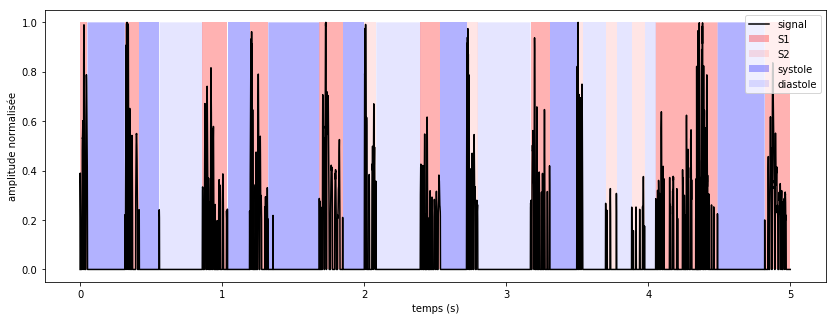

In [76]:
plt.figure(figsize=(14,5))
l = len(segmentation)
x = np.linspace(0,l/2000,l)
plt.fill_between(x,0,1,where = segmentation=='S1',facecolor='r',alpha=.3,label='S1')
plt.fill_between(x,0,1,where = segmentation=='S2',facecolor='r',alpha=.1,label='S2')
plt.fill_between(x,0,1,where = segmentation=='systole',facecolor='b',alpha=.3,label='systole')
plt.fill_between(x,0,1,where = segmentation=='diastole',facecolor='b',alpha=.1,label='diastole')

plt.plot(x,E/np.max(E),'k',label='signal')
plt.legend()
plt.xlabel('temps (s)')
plt.ylabel('amplitude normalisée')

## Test MFCC

In [44]:
X = np.zeros(40)
for i in range(n_samples):
    sample = raw_data.loc[i]
    pcg = PCG(sample)
    seg,E,lag,counter = pcg.segmentation()
    borne = pcg.computeBorne(seg)
    ft = np.zeros(1)
    for phase in phases_list:
        mfccs = pcg.computeMFCC(seg,borne,phase,lag)
        try:
            ft = np.concatenate((ft,mfccs))
        except:
            print('sample {},phase {},shape {}'.format(i,phase,mfccs.shape))
            pass
    X = np.row_stack((X,ft[1:]))
X = X[1:]

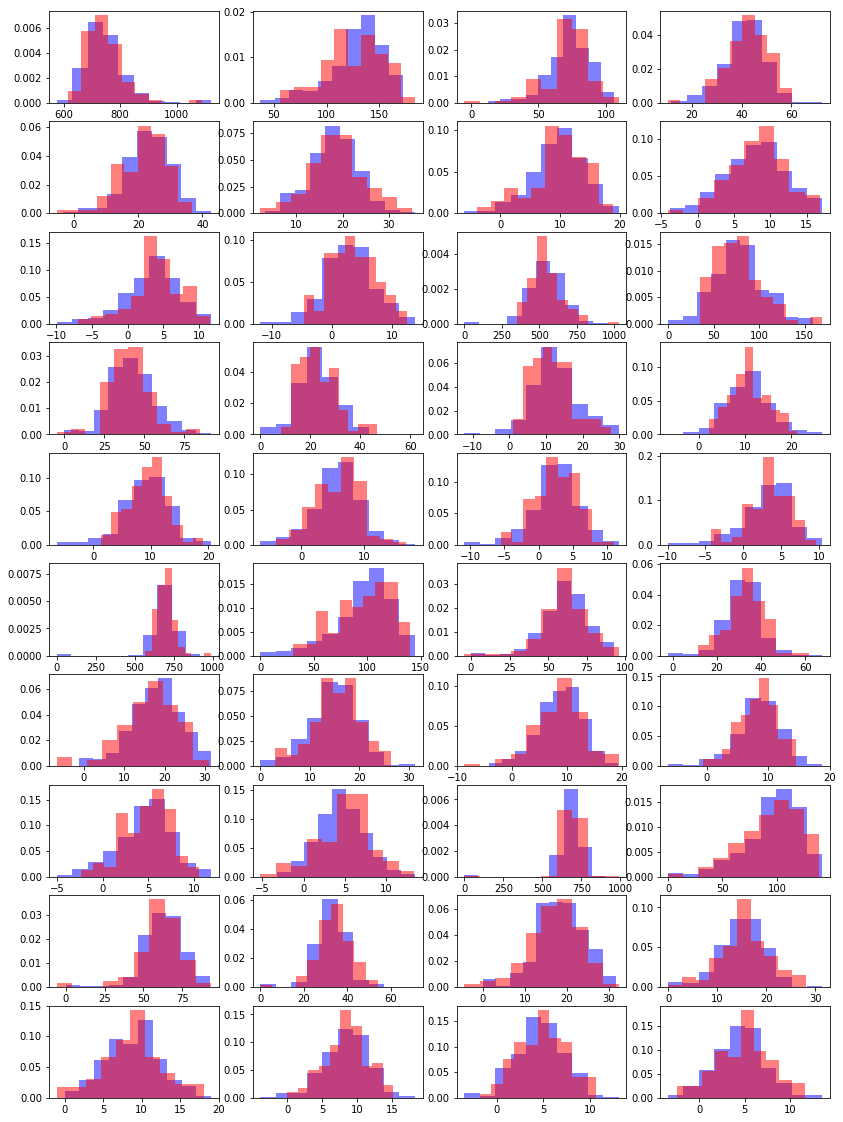

In [47]:
fig = plt.figure(figsize=(14,20))
for i in range(40):
    ax = fig.add_subplot(10,4,i+1)
    tho = X[:,i]
    ax.hist(tho[labels==1],density=True,alpha=0.5,color='b')
    ax.hist(tho[labels==-1],density=True,alpha=0.5,color='r')

## Analyse des features

In [82]:
n_samples = dataset.shape[0]

In [87]:
sample = dataset[0]
pcg = PCG(sample)
features = pcg.extractFeatures()
features.shape

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:262: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


(85,)

In [88]:
X = np.zeros(85)
final_labels = []
for i in range(n_samples):
    try:
        sample = dataset[i]
        pcg = PCG(sample)
        ft = pcg.extractFeatures()
        X = np.row_stack((X,ft))
        final_labels.append(labels[i])
        
    except:
        print('il y a une erreur avec le sample %d'%i)
X = X[1:]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:262: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/anaconda3/lib/python3.7/site-packages/numpy/

In [107]:
out = np.load('features_ab.npz')

In [108]:
X,labels = out['arr_0'],out['arr_1']

In [109]:
labels.shape

(898,)

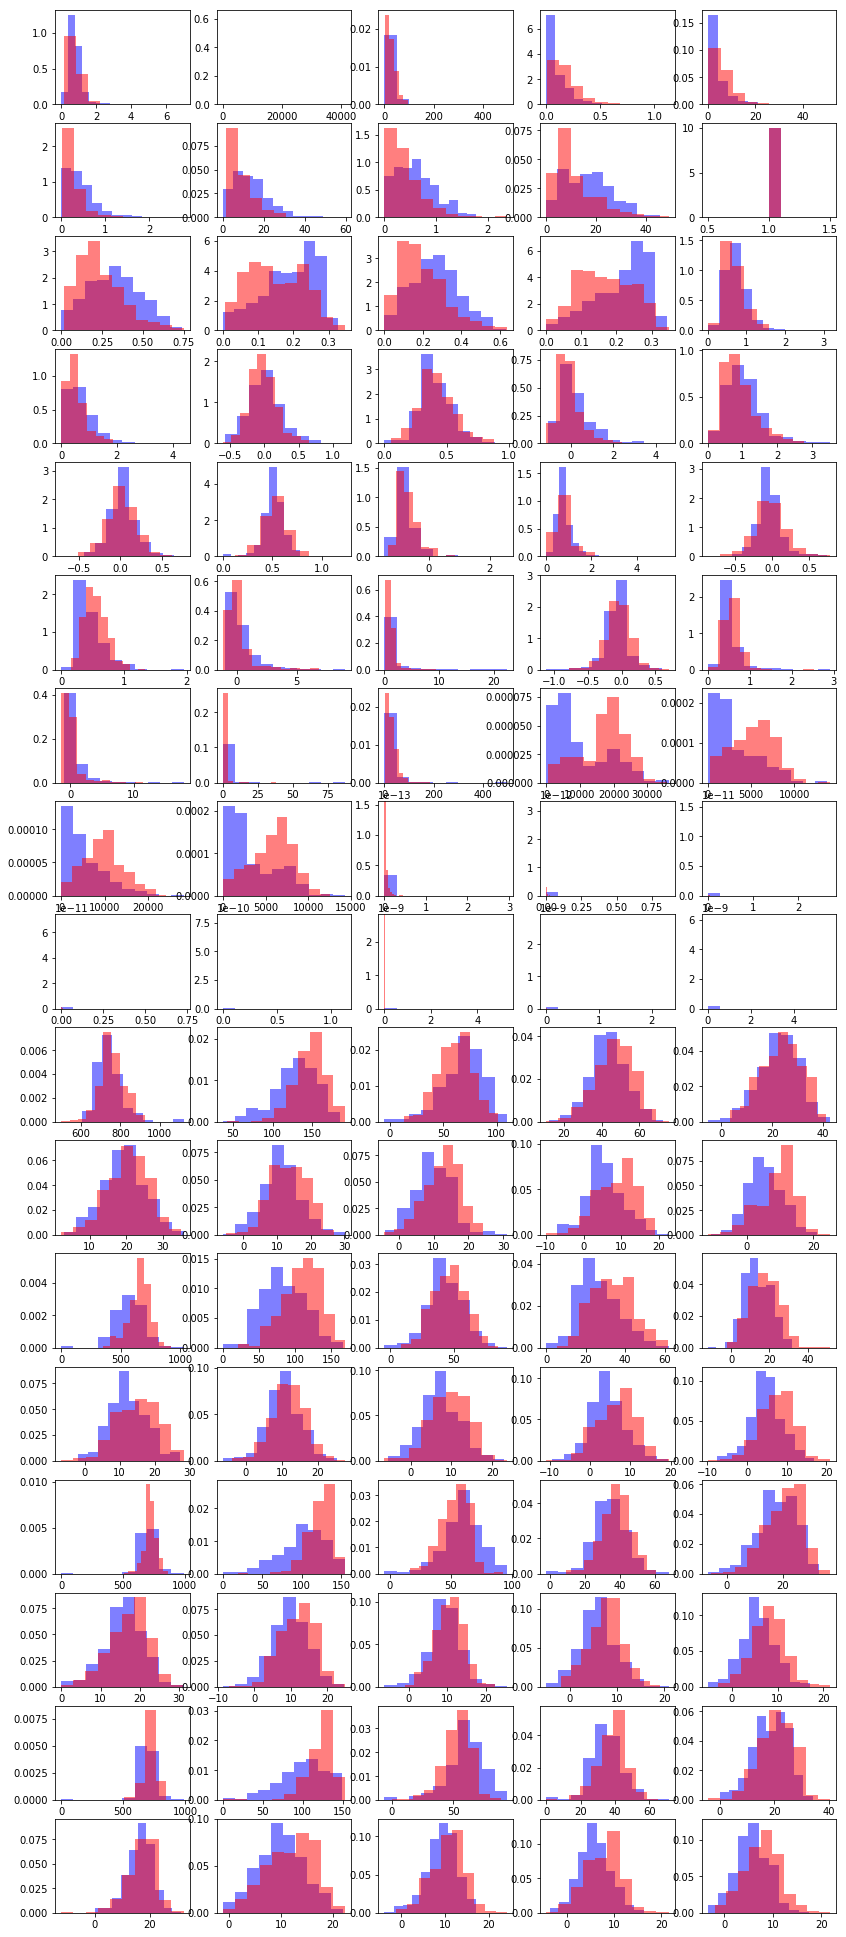

In [111]:
fig = plt.figure(figsize=(14,35))
for i in range(85):
    ax = fig.add_subplot(17,5,i+1) #add_subplot(nb lignes, nb colonnes,place)
    ft = X[:,i]
    normalft = ft[labels==1]
    anormalft = ft[labels==-1]
    ax.hist(normalft,density=True,color='b',alpha=0.5)
    ax.hist(anormalft,density=True,color='r',alpha=0.5)

## Classification

Le score qui nous intéresse est le recall: TP/(TP+FN), où TP sont les malades correctement reperés

In [118]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,recall_score,accuracy_score

In [119]:
from sklearn.preprocessing import normalize
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [48]:
np.random.seed(0)

In [102]:
pca = PCA(n_components = 20)

In [103]:
X_norm = normalize(X)

In [104]:
xtrain,xtest,ytrain,ytest = train_test_split(X,labels,test_size = 0.3)
xtrain_red = pca.fit_transform(xtrain)
xtest_red = pca.transform(xtest)

Le recall du hasard est de 0.5, le recall "standard" (d'un algorithme qui prédirait toujours la maladie) donne

In [105]:
np.sum(ytest==-1)/ytest.shape[0]

0.5333333333333333

Faisons un benchmark, pour sélectionner le modèle que nous optimiserons pour la suite

In [124]:
rf = RandomForestClassifier(n_estimators=100,max_depth=None)
svm = SVC(C=0.1,gamma=1)
logit = LogisticRegression()
gradb = GradientBoostingClassifier()
dtree = DecisionTreeClassifier()
nn = MLPClassifier()
classifiers_list = ['regression logisitique',
                   'reseau de neurones',
                   'arbre de decision',
                   'svm',
                   'gradient boosting',
                   'random forest']
for i,clf in enumerate([logit,nn,dtree,svm,gradb,rf]):
    clf.fit(xtrain_red,ytrain)
    ypred = clf.predict(xtest_red)
    recall = recall_score(ytest,ypred,pos_label=-1,average='binary')
    accuracy = accuracy_score(ytest,ypred)
    print('Pour le {} recall={},accuracy={}'.format(classifiers_list[i],recall,accuracy))

Pour le regression logisitique recall=0.7152777777777778,accuracy=0.7185185185185186
Pour le reseau de neurones recall=0.4722222222222222,accuracy=0.6370370370370371
Pour le arbre de decision recall=0.6875,accuracy=0.6666666666666666
Pour le svm recall=1.0,accuracy=0.5333333333333333
Pour le gradient boosting recall=0.8263888888888888,accuracy=0.7296296296296296
Pour le random forest recall=0.8888888888888888,accuracy=0.7666666666666667


La **random forest** donne les meilleurs scores (aussi bien recall que accuracy). <br> A noter, le SVM donne un meilleur recall mais son accuracy nous montre qu'en fait il prédit toujours "malade".

## Hyperparameter tuning for Random Forest & gradient boosting

In [60]:
import cma

In [73]:
def objective_functionGB(params):
    n_estimators,max_depth,learning_rate,max_features = params[0],params[1],params[2],params[3]
    model = GradientBoostingClassifier(n_estimators=n_estimators,
                                       learning_rate=learning_rate,
                                       max_depth=max_depth,
                                       max_features=params[3])
    model.fit(xtrain_red,ytrain)
    return recall_score(ytest,model.predict(xtest_red),pos_label=-1,average='binary')

In [ ]:
n_estimators_range = [10,50,100,500]
max_depth_range = range(1,10)

In [74]:
for ne in n_estimators_range:
    for md in max_depth_rage:
        opt = cma.fmin(objective_function=objective_functionGB,
               x0=[0.1,0.5],
               sigma0=1e-3,
               )

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=529810, Fri Dec 21 12:49:57 2018)


TypeError: 'numpy.float64' object cannot be interpreted as an integer